In [1]:
!pip install tldextract catboost -q
!pip install lightgbm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 4.0 MB/s eta 0:00:00


*****
# Necessary Imports & Constants

In [175]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import math
import time
import joblib
import tldextract

from tqdm import tqdm
from urllib.parse import urlparse
from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, classification_report, f1_score, 
                confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_auc_score)

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier

tqdm.pandas()
warnings.filterwarnings('ignore')

In [5]:
# global path
path = os.getcwd()
os.makedirs('results', exist_ok=True)
os.makedirs('models', exist_ok=True)

*****
# Dataset

In [4]:

df = pd.read_csv(path+"/data/malicious_phish.csv")
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [5]:
print(df.shape)
print(df.info())

(651191, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB
None


In [6]:
def plot_distribution(df, labels, name):
    plt.figure(figsize=(10, 7))
    unique_classes = df[labels].unique()
    ax = sns.countplot(data=df, x=labels, palette=sns.color_palette("husl", len(unique_classes)))
    for x in ax.patches:
        height = x.get_height()
        ax.annotate(f"{int(height)}", (x.get_x()+x.get_width()/2, height),
                    ha='center', va='bottom', fontsize=12, color='black')
    plt.title("Dataset Class Distribution")
    plt.xlabel("URL Types")
    plt.ylabel("URL Count")

    plt.grid(axis='y')
    plt.savefig(path+'/results'+name)
    plt.show()    

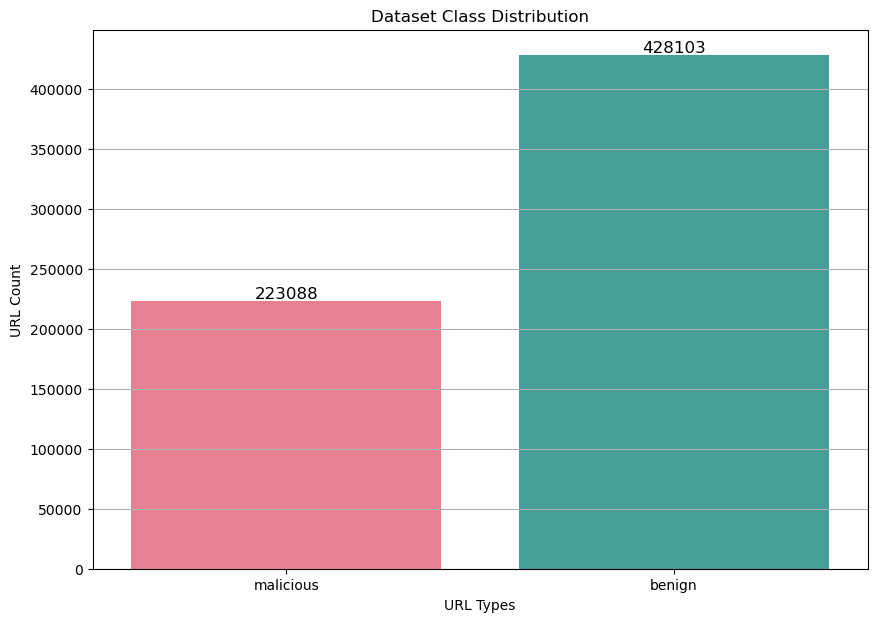

In [7]:
# generate a temp binary column and plot the class distributions
df['status'] = df['type'].apply(lambda x: 'benign' if x =='benign' else 'malicious')

plot_distribution(df, 'status', '/binary_class_distribution.png')

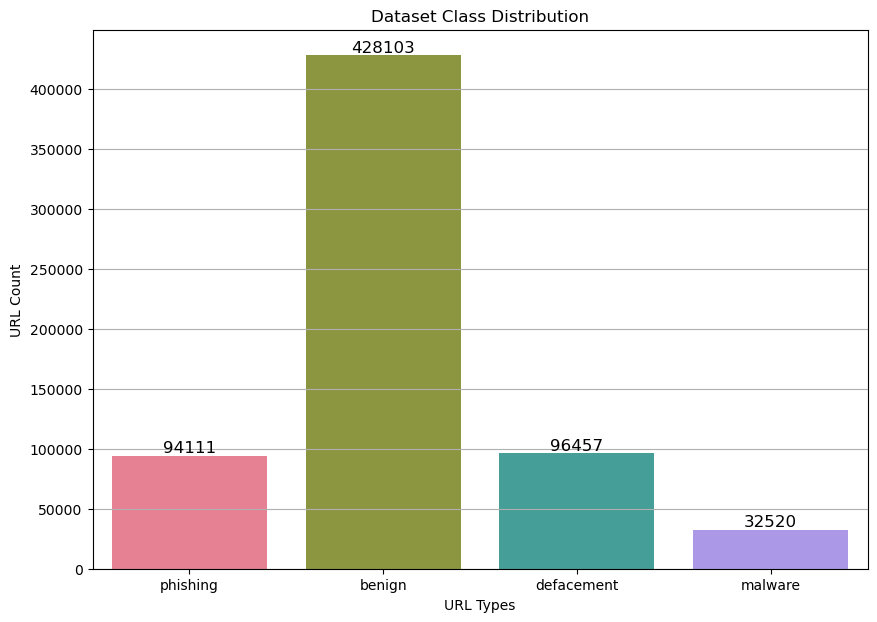

In [8]:
#plot the multi-class distributions
plot_distribution(df, 'type', '/multi_class_distribution.png')

In [9]:
# find duplicate rws
dp = df.duplicated().sum()
print(f"Duplicate Samples: {dp}")

# remove duplicate rws
df.drop_duplicates(inplace=True)

Duplicate Samples: 10066


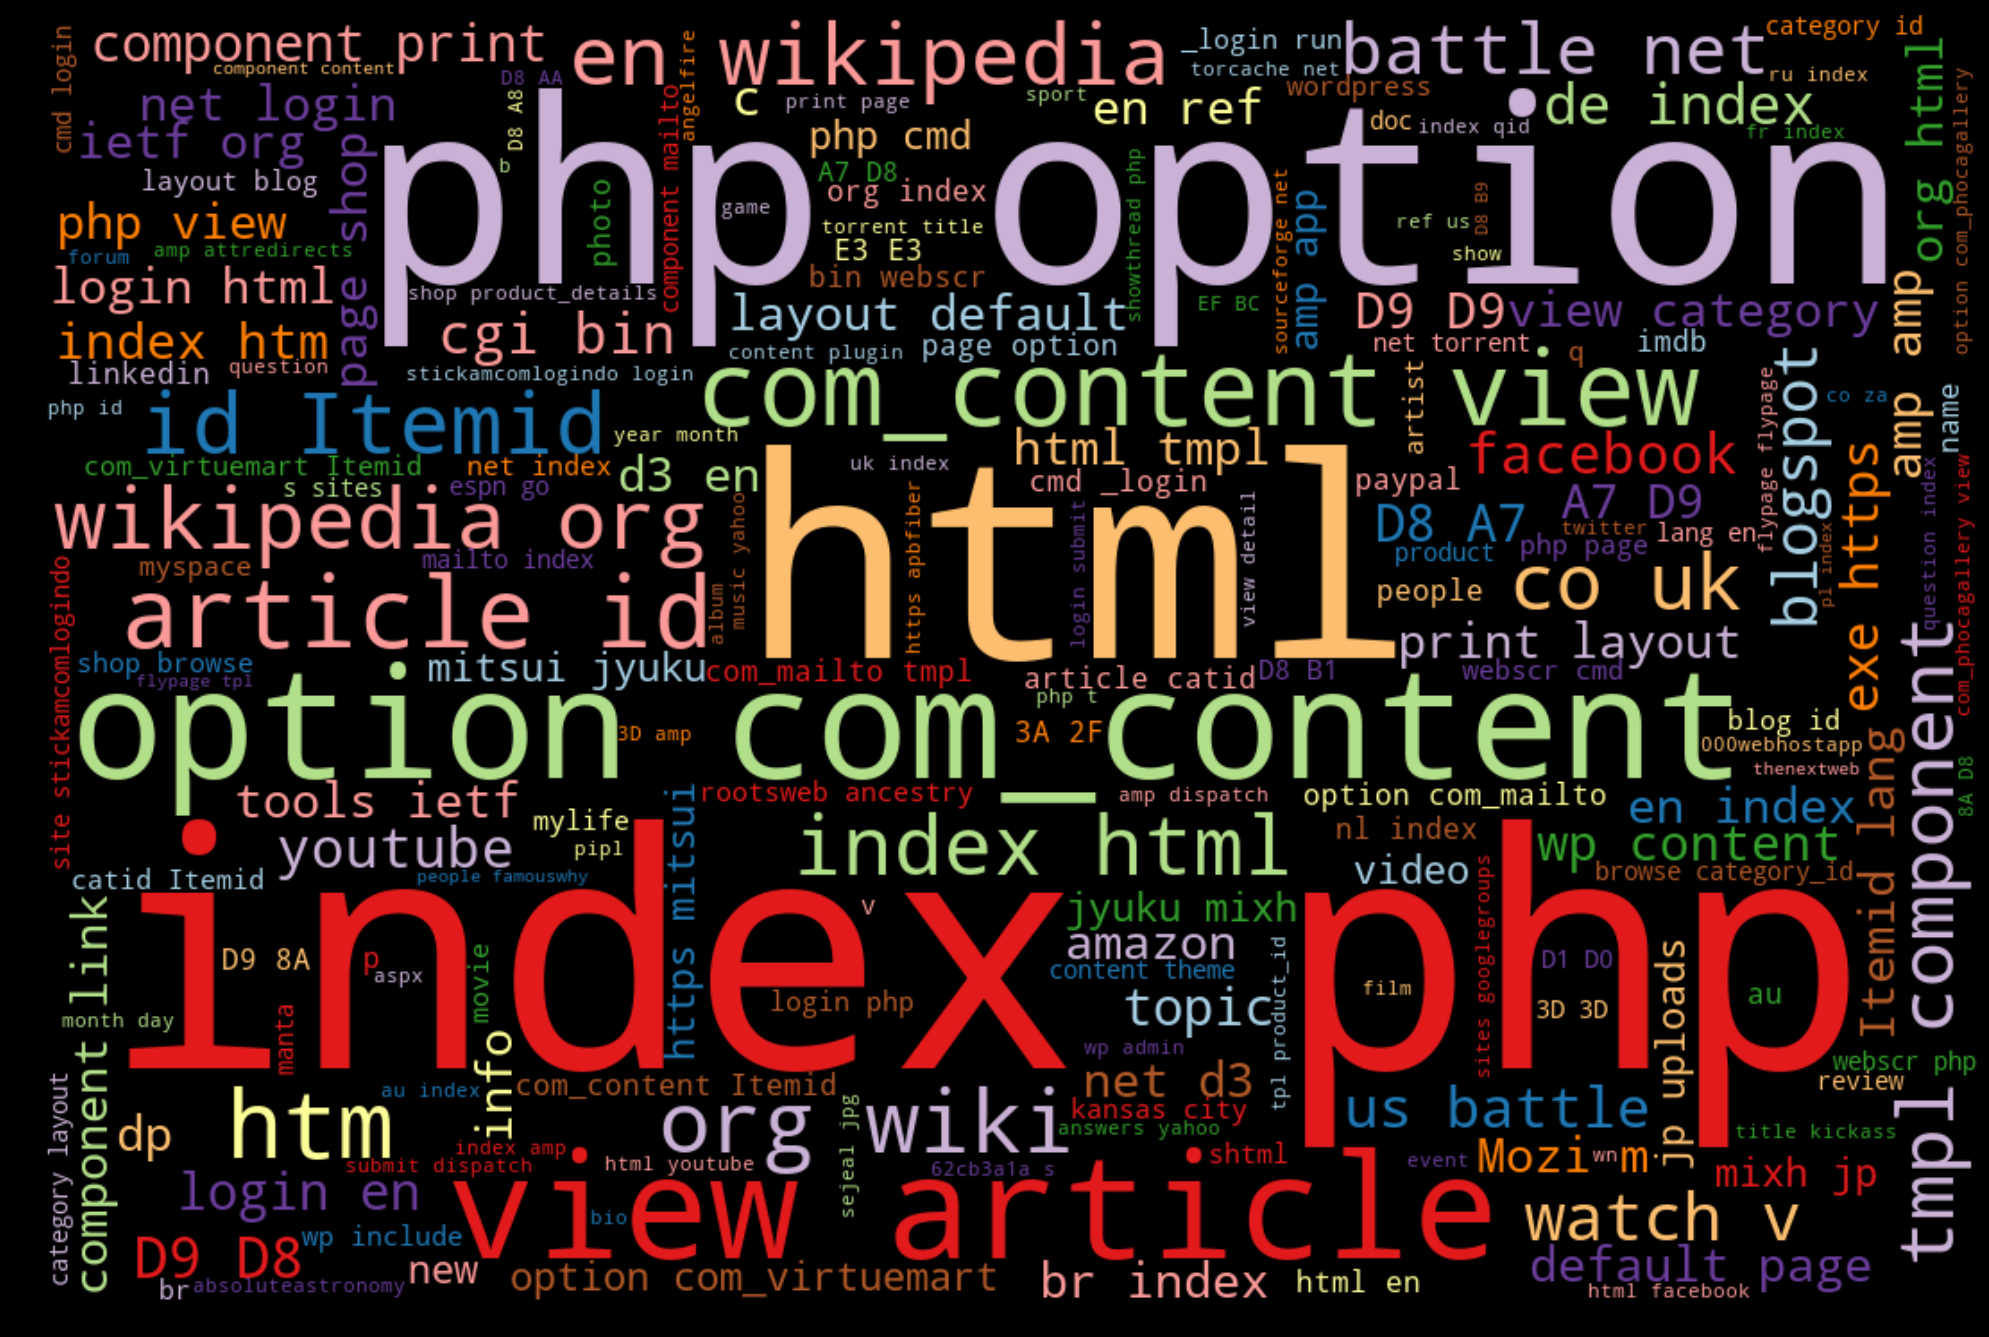

In [10]:
url_word = " ".join(i for i in df.url)
wordcloud = WordCloud(width=1080, height=720, colormap='Paired').generate(url_word)
plt.figure(figsize=(20, 14), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout()
plt.savefig(path+'/results/img.png')
plt.show()

*****
# Helper Function

In [6]:
def reduce_memory_size(df):
    """Reduce memory size of the DataFrame

    Args:
        df (pd.DataFrame): The input DataFrame

    Returns:
        pd.DataFrame: The modified DataFrame with reduced memory size
    """
    initial_size = df.memory_usage(deep=True).sum() / 1024**2   # calculate initial memory size
    print(f"Initial Memory Size: {initial_size:.2f} MB")

    for column in df.columns:
        if pd.api.types.is_integer_dtype(df[column]):
            # downcast the integer columns to the smallest possible types
            df[column] = pd.to_numeric(df[column], downcast='integer')  
        elif pd.api.types.is_float_dtype(df[column]):
            # downcast the float columns to the smallest possible types
            df[column] = pd.to_numeric(df[column], downcast='float')
        else:
            pass  

    updated_size = df.memory_usage(deep=True).sum() / 1024**2   # calculate updated memory size
    print(f"Updated Memory Size: {updated_size:.2f} MB")
    print(f"Memory Usage Reduced by: {initial_size - updated_size:.2f} MB")     # calculate the memory reduced
    print(f"this is: {100*(updated_size/initial_size):.2f}% of the initial size")   # calculate the percentage of memory reduced

    return df

def measure_time(sec, name, Tune=False):
    """ Measure the time taken for training the model """
    hours, rem = divmod(sec, 3600)
    minutes, seconds = divmod(rem, 60)
    if Tune:
        print(f"{name} Hyperparameter Tuning Time: {int(hours)}h {int(minutes)}m {int(seconds)}s \n")
    else:
        print(f"{name} Training Time: {int(hours)}h {int(minutes)}m {int(seconds)}s \n")

In [7]:
def evaluate_model(model, name, X_train, train_true, X_test, test_true, results_df, class_names, path):
    """Evaluates the classification model and appends results to results_df."""
    # Predictions
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    # Accuracy
    train_acc = accuracy_score(train_true, pred_train)
    test_acc = accuracy_score(test_true, pred_test)

    # Metrics (weighted handles class imbalance well; use 'macro' if equal weight to all classes)
    precision = precision_score(test_true, pred_test, average='weighted')
    recall = recall_score(test_true, pred_test, average='weighted')
    f1 = f1_score(test_true, pred_test, average='weighted')

    # Print summary
    print("=" * 100)
    print(f"             {name} Classification Results \n")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1 Score:       {f1:.4f}")
    print("=" * 100)
    
    print()
    # Prepare ordered class labels
    ordered_labels = [k for k, _ in sorted(class_names.items(), key=lambda x: x[1])]
    
    print("=" * 100)
    print(f"             {name} Classification Report \n")
    print(classification_report(test_true, pred_test, target_names=ordered_labels))
    print("=" * 100)

    # Confusion Matrix
    cm = confusion_matrix(test_true, pred_test)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=ordered_labels, yticklabels=ordered_labels)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(path+'cm.png')
    plt.show()

    # Precision-Recall Curve
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
        n_classes = len(ordered_labels)

        plt.figure(figsize=(8, 5))
        for i in range(n_classes):
            true_binary = (test_true == i).astype(int)
            score = y_score[:, i]
            precision_i, recall_i, _ = precision_recall_curve(true_binary, score)
            plt.plot(recall_i, precision_i, label=f"Class {ordered_labels[i]}")
        plt.title(f'Precision-Recall Curve - {name}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.grid(True)
        plt.savefig(path+'rp_curve.png')
        plt.show()

    # Append to DataFrame
    new_row = pd.DataFrame([{
        'model_name': name,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1score': f1
    }])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    return results_df

In [8]:
def plot_chart(df, label, kind):
    plt.figure(figsize=(6, 5))  # width=8, height=5 inches
    df[label].value_counts().plot(kind=kind)
    plt.ylabel("Count")
    plt.title("Distribution")
    plt.grid(axis='y')
    plt.show()


*****
# Feature Extraction from URLs

In [176]:
def get_feature(url) -> dict:
    try:
        def has_ip(url:str) -> int:
            return 1 if re.search(r"\d+\.\d+\.\d+\.\d+", url) else 0

        def calculate_entropy(url:str) -> float:
            if not url:
                return 0.0
            count = Counter(url)
            total = len(url)
            entropy = -sum((freq / total) * math.log2(freq / total) for freq in count.values())
            return entropy
        
        def get_domain_name(url: str) -> str:
            ext = tldextract.extract(url)
            # find the top level domain or unknown domain 
            return ext.domain.lower() if ext.domain else 'unknown'
        
        parsed = urlparse(url)
        domain = parsed.netloc
        path = parsed.path
        return {
            'domain_name': get_domain_name(url),
            'entropy_score': calculate_entropy(url),
            'url_length': len(url),
            'domain_length': len(domain),
            'path_length': len(path),
            'num_subdomains': domain.count('.'),
            'count_dash': url.count('-'),
            'count_dot': url.count('.'),
            'count_at': url.count('@'),
            'count_sharp': url.count('#'),
            'count_qus': url.count('?'),
            'count_eql': url.count('='),
            'count_and': url.count('&'),
            'count_slash': url.count('/'),
            'count_percent': url.count('%'),
            'count_dollar': url.count('$'),
            'count_digit': sum(c.isdigit() for c in url),
            'has_ip': has_ip(url),
            'has_http': 1 if parsed.scheme == 'http' else 0,
            'has_https': 1 if parsed.scheme == 'https' else 0,
            'has_suspicious_tld': 1 if domain.endswith(('.tk','.zip','.gq', '.ml')) else 0,
            'has_login_keyword': 1 if re.search(f'login|secure|account|verify|update|account|bank|free|offer|bonus', url.lower()) else 0
        }
    except Exception as e:
        print(f"Error processing URL: {url}: {e}")

In [14]:
# drop the temp status column
df = df.drop('status', axis = 1)

In [15]:
# # apply feature extraction 
# df['features'] = df['url'].progress_apply(get_feature)
# feature_df = pd.json_normalize(df['features'])
# df = df.drop(columns='features').join(feature_df)

In [16]:
features_list = []
urls = df['url'].tolist()

for i, url in enumerate(tqdm(urls, desc="Extracting features")):
    try:
        features = get_feature(url)
    except Exception as e:
        print(f"Error at index {i}, URL: {url}, Reason: {e}")
        features = {}  # or fill with fallback values as needed
    features_list.append(features)

feature_df = pd.DataFrame(features_list)
df = df.reset_index(drop=True).join(feature_df)

Extracting features: 100%|██████████| 641125/641125 [00:22<00:00, 28011.84it/s]


*****
# Data Exploration

In [17]:
print(df.shape)
df.head()

(641125, 24)


,url,type,domain_name,entropy_score,url_length,domain_length,path_length,num_subdomains,count_dash,count_dot,...,count_and,count_slash,count_percent,count_dollar,count_digit,has_ip,has_http,has_https,has_suspicious_tld,has_login_keyword
0,br-icloud.com.br,phishing,br-icloud,3.375000,16,0,16,0,1,2,...,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,mp3raid,4.079143,35,0,35,0,0,2,...,0,2,0,0,1,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets,3.708093,31,0,31,0,0,2,...,0,3,0,0,1,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,garage-pirenne,4.660343,88,21,10,2,1,3,...,3,3,0,0,7,0,1,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,adventure-nicaragua,5.491293,235,23,10,1,1,2,...,2,3,0,0,22,0,1,0,0,0


In [18]:
df = reduce_memory_size(df)

Initial Memory Size: 239.61 MB
Updated Memory Size: 154.62 MB
Memory Usage Reduced by: 84.99 MB
this is: 64.53% of the initial size


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641125 entries, 0 to 641124
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   url                 641125 non-null  object 
 1   type                641125 non-null  object 
 2   domain_name         641125 non-null  object 
 3   entropy_score       641125 non-null  float32
 4   url_length          641125 non-null  int16  
 5   domain_length       641125 non-null  int16  
 6   path_length         641125 non-null  int16  
 7   num_subdomains      641125 non-null  int8   
 8   count_dash          641125 non-null  int8   
 9   count_dot           641125 non-null  int8   
 10  count_at            641125 non-null  int8   
 11  count_sharp         641125 non-null  int8   
 12  count_qus           641125 non-null  int8   
 13  count_eql           641125 non-null  int8   
 14  count_and           641125 non-null  int8   
 15  count_slash         641125 non-nul

In [20]:
df.describe()

,entropy_score,url_length,domain_length,path_length,num_subdomains,count_dash,count_dot,count_at,count_sharp,count_qus,...,count_and,count_slash,count_percent,count_dollar,count_digit,has_ip,has_http,has_https,has_suspicious_tld,has_login_keyword
count,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000,...,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000,641125.000000
mean,4.217499,59.762232,4.887371,41.076592,0.500397,1.561355,2.193950,0.002243,0.000884,0.221389,...,0.370616,2.921895,0.398485,0.000242,5.371773,0.019630,0.253175,0.024390,0.000268,0.064059
std,0.415346,44.894451,8.889544,29.820412,0.947548,2.984733,1.491443,0.054507,0.032579,0.440002,...,1.197641,1.895775,4.166358,0.023728,11.630189,0.138724,0.434831,0.154257,0.016377,0.244859
min,-0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.961406,32.000000,0.000000,21.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.225935,47.000000,0.000000,35.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,3.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.492926,76.000000,10.000000,53.000000,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,...,0.000000,4.000000,0.000000,0.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,7.504113,2175.000000,236.000000,2175.000000,26.000000,87.000000,42.000000,10.000000,6.000000,20.000000,...,50.000000,41.000000,231.000000,6.000000,1204.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
# checking for null values
df.isna().sum()

url                   0
type                  0
domain_name           0
entropy_score         0
url_length            0
domain_length         0
path_length           0
num_subdomains        0
count_dash            0
count_dot             0
count_at              0
count_sharp           0
count_qus             0
count_eql             0
count_and             0
count_slash           0
count_percent         0
count_dollar          0
count_digit           0
has_ip                0
has_http              0
has_https             0
has_suspicious_tld    0
has_login_keyword     0
dtype: int64

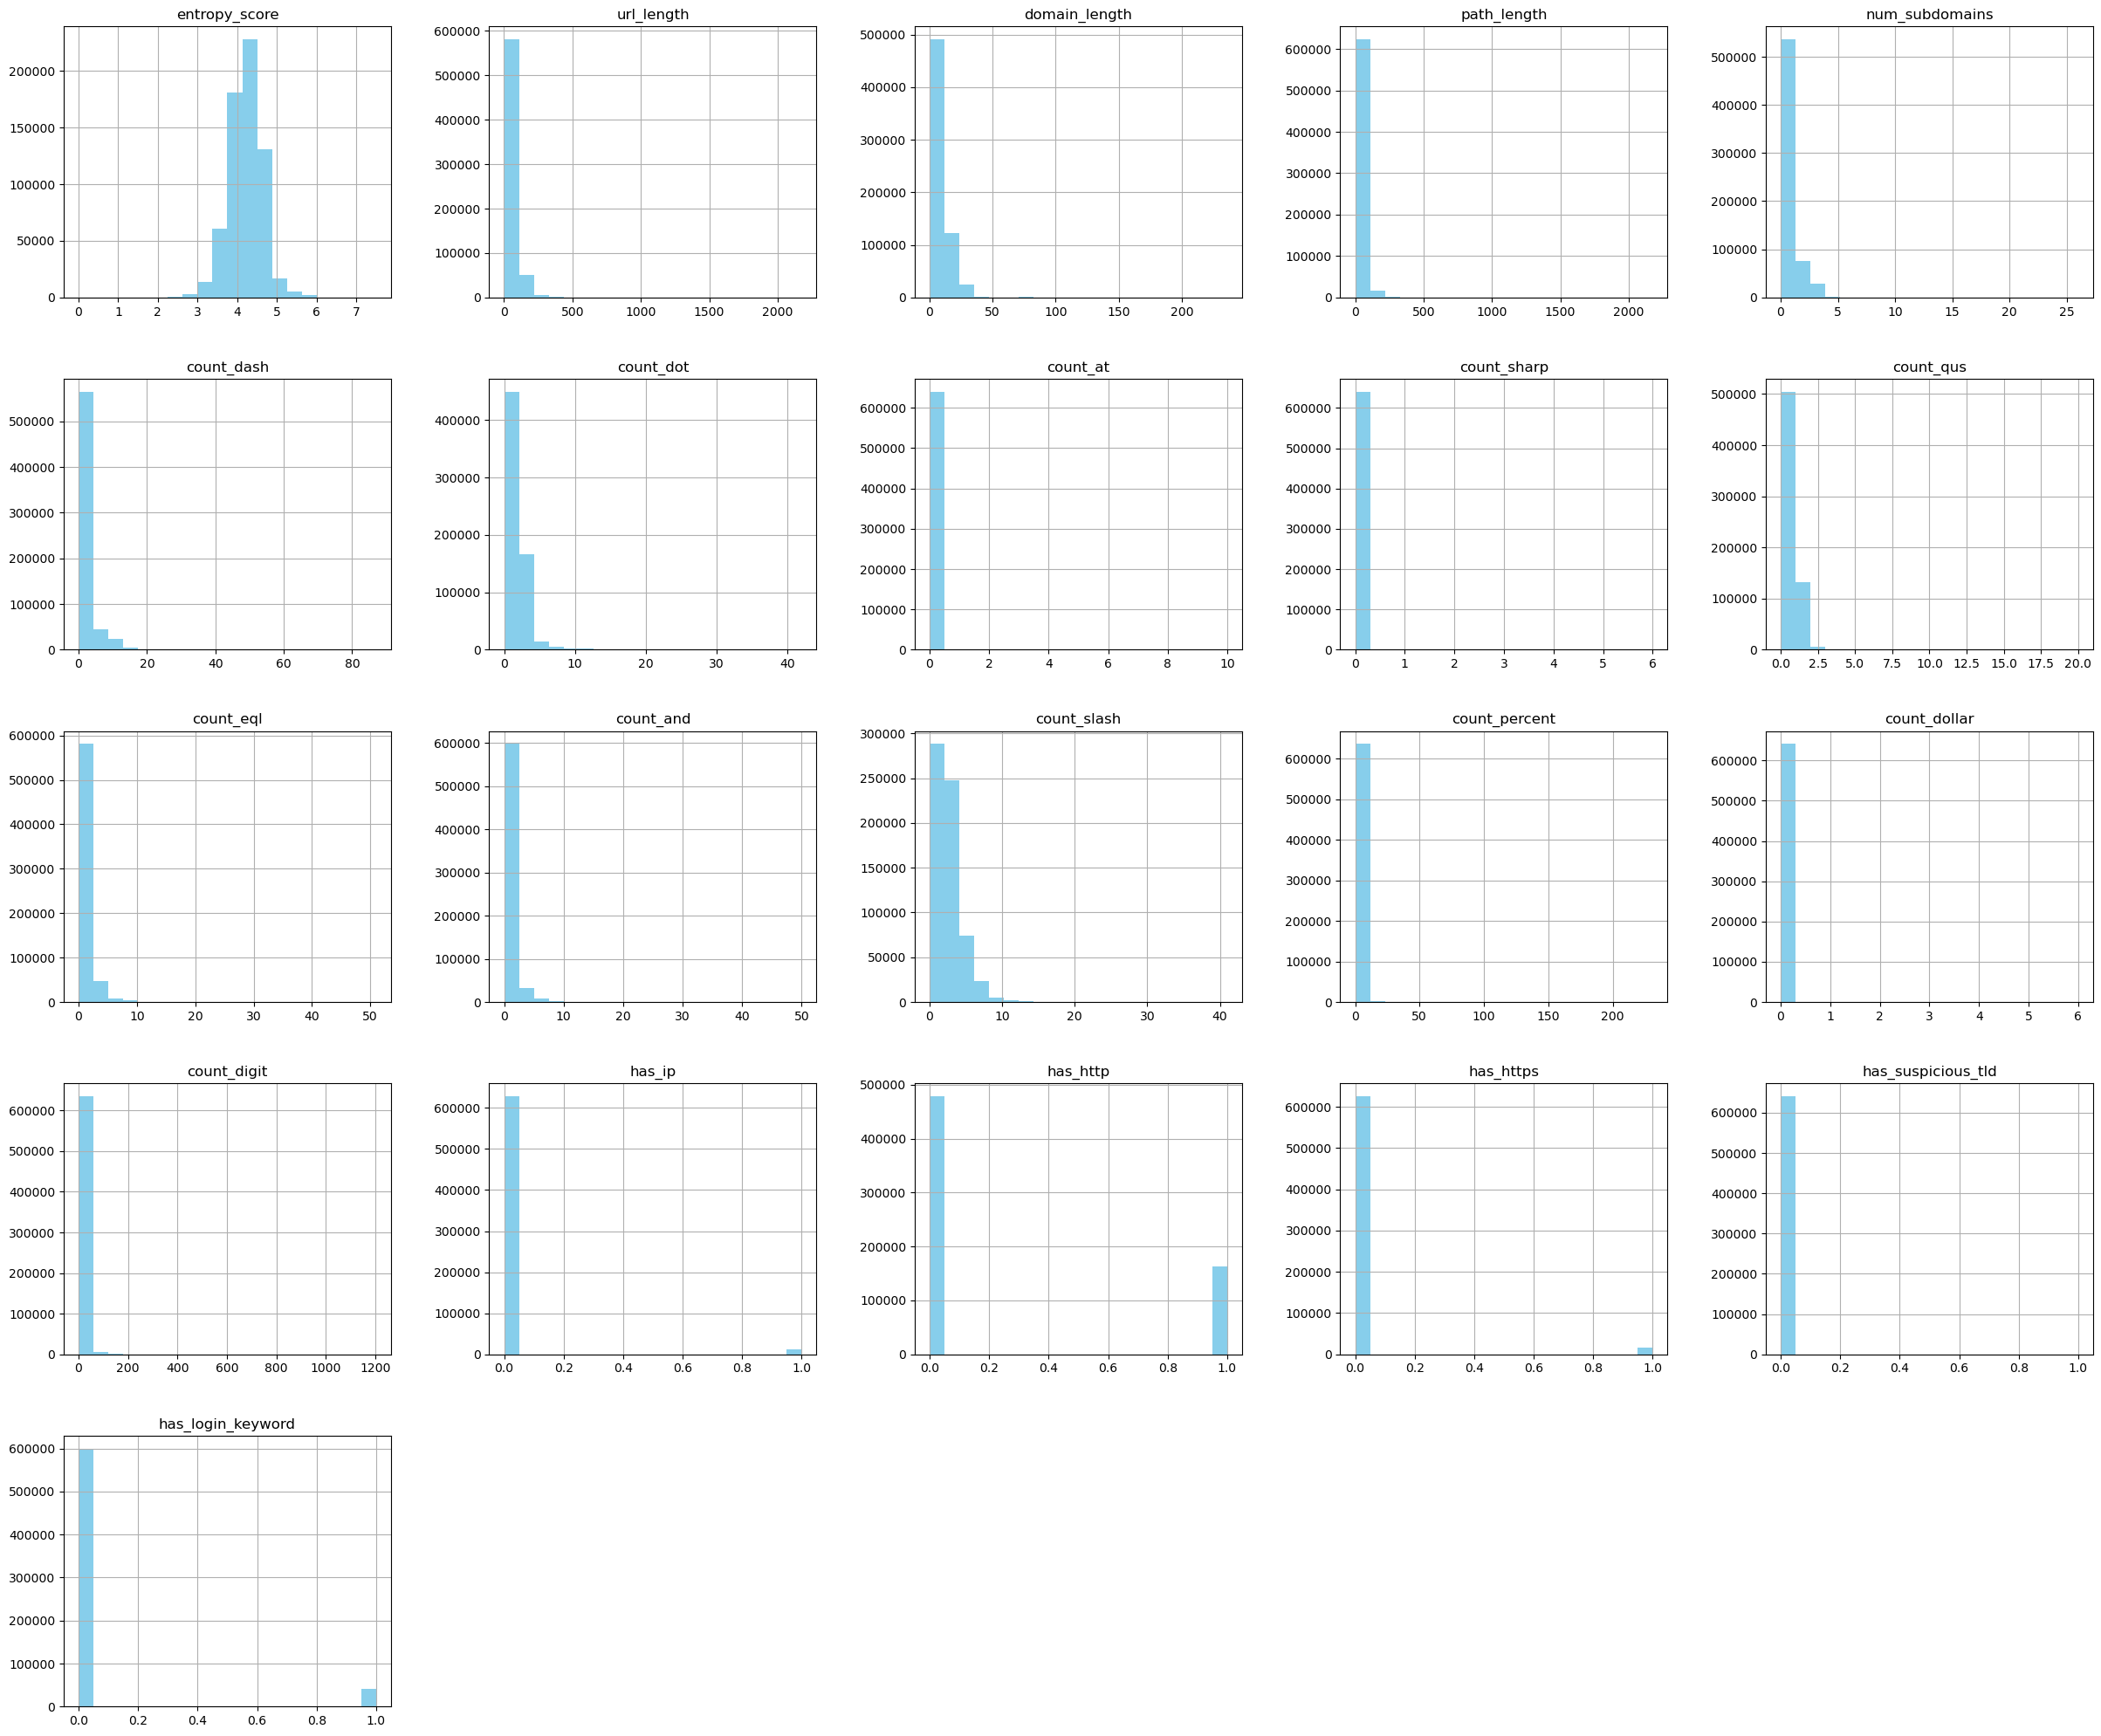

In [22]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numerical_cols].hist(bins=20, figsize=(30, 25), color='skyblue')
plt.show()

In [23]:
print(f"Total Number of Unique Domains: {len(df['domain_name'].unique())}")

Total Number of Unique Domains: 152267


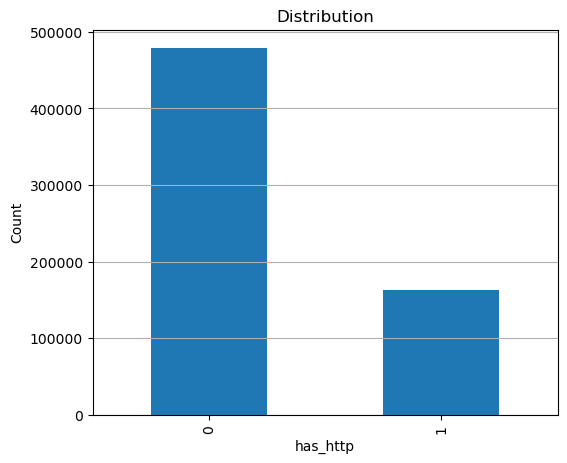

In [24]:
plot_chart(df, 'has_http', 'bar')

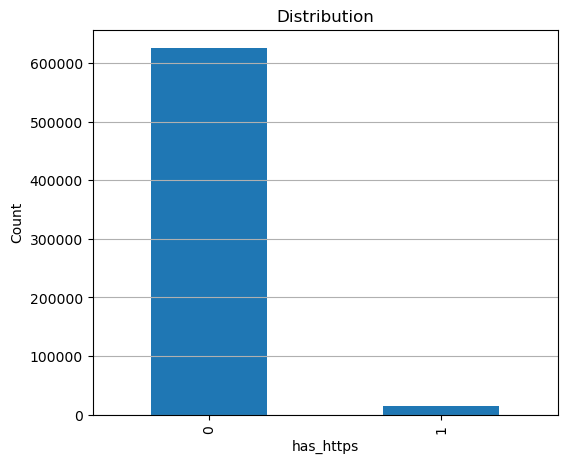

In [25]:
plot_chart(df, 'has_https', 'bar')

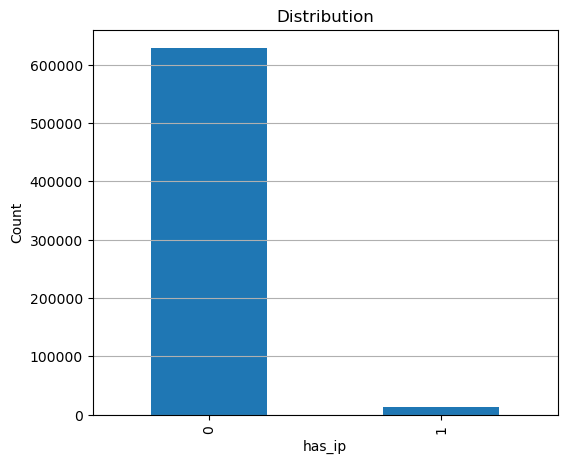

In [26]:
plot_chart(df, 'has_ip', 'bar')

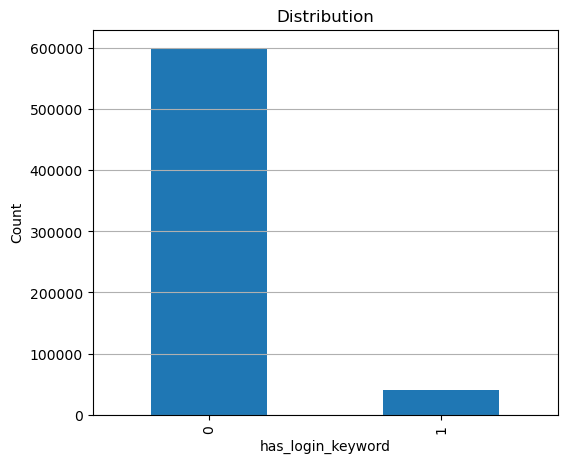

In [27]:
plot_chart(df, 'has_login_keyword', 'bar')

*****
# Pre-Processing

In [28]:
df.head()

,url,type,domain_name,entropy_score,url_length,domain_length,path_length,num_subdomains,count_dash,count_dot,...,count_and,count_slash,count_percent,count_dollar,count_digit,has_ip,has_http,has_https,has_suspicious_tld,has_login_keyword
0,br-icloud.com.br,phishing,br-icloud,3.375000,16,0,16,0,1,2,...,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,mp3raid,4.079144,35,0,35,0,0,2,...,0,2,0,0,1,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets,3.708093,31,0,31,0,0,2,...,0,3,0,0,1,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,garage-pirenne,4.660343,88,21,10,2,1,3,...,3,3,0,0,7,0,1,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,adventure-nicaragua,5.491293,235,23,10,1,1,2,...,2,3,0,0,22,0,1,0,0,0


In [29]:
# droping domain_name and url column
df = df.drop(columns=['domain_name', 'url'], axis=1)

# saving the final dataset
df.to_csv('./data/classifier_dataset.csv')

In [30]:
df.head()

,type,entropy_score,url_length,domain_length,path_length,num_subdomains,count_dash,count_dot,count_at,count_sharp,...,count_and,count_slash,count_percent,count_dollar,count_digit,has_ip,has_http,has_https,has_suspicious_tld,has_login_keyword
0,phishing,3.375000,16,0,16,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,benign,4.079144,35,0,35,0,0,2,0,0,...,0,2,0,0,1,0,0,0,0,0
2,benign,3.708093,31,0,31,0,0,2,0,0,...,0,3,0,0,1,0,0,0,0,0
3,defacement,4.660343,88,21,10,2,1,3,0,0,...,3,3,0,0,7,0,1,0,0,0
4,defacement,5.491293,235,23,10,1,1,2,0,0,...,2,3,0,0,22,0,1,0,0,0


#### Split dataset and encode

In [31]:
# spliting dataset
X = df.drop('type', axis=1)
y = df['type']

# encode the target column
le = LabelEncoder()
y = le.fit_transform(y)

class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Encoded Classes: ")
print(class_mapping)

Encoded Classes: 
{'benign': 0, 'defacement': 1, 'malware': 2, 'phishing': 3}


In [32]:
# save the encoder
joblib.dump(le, './files/decoder.pkl')

['./files/decoder.pkl']

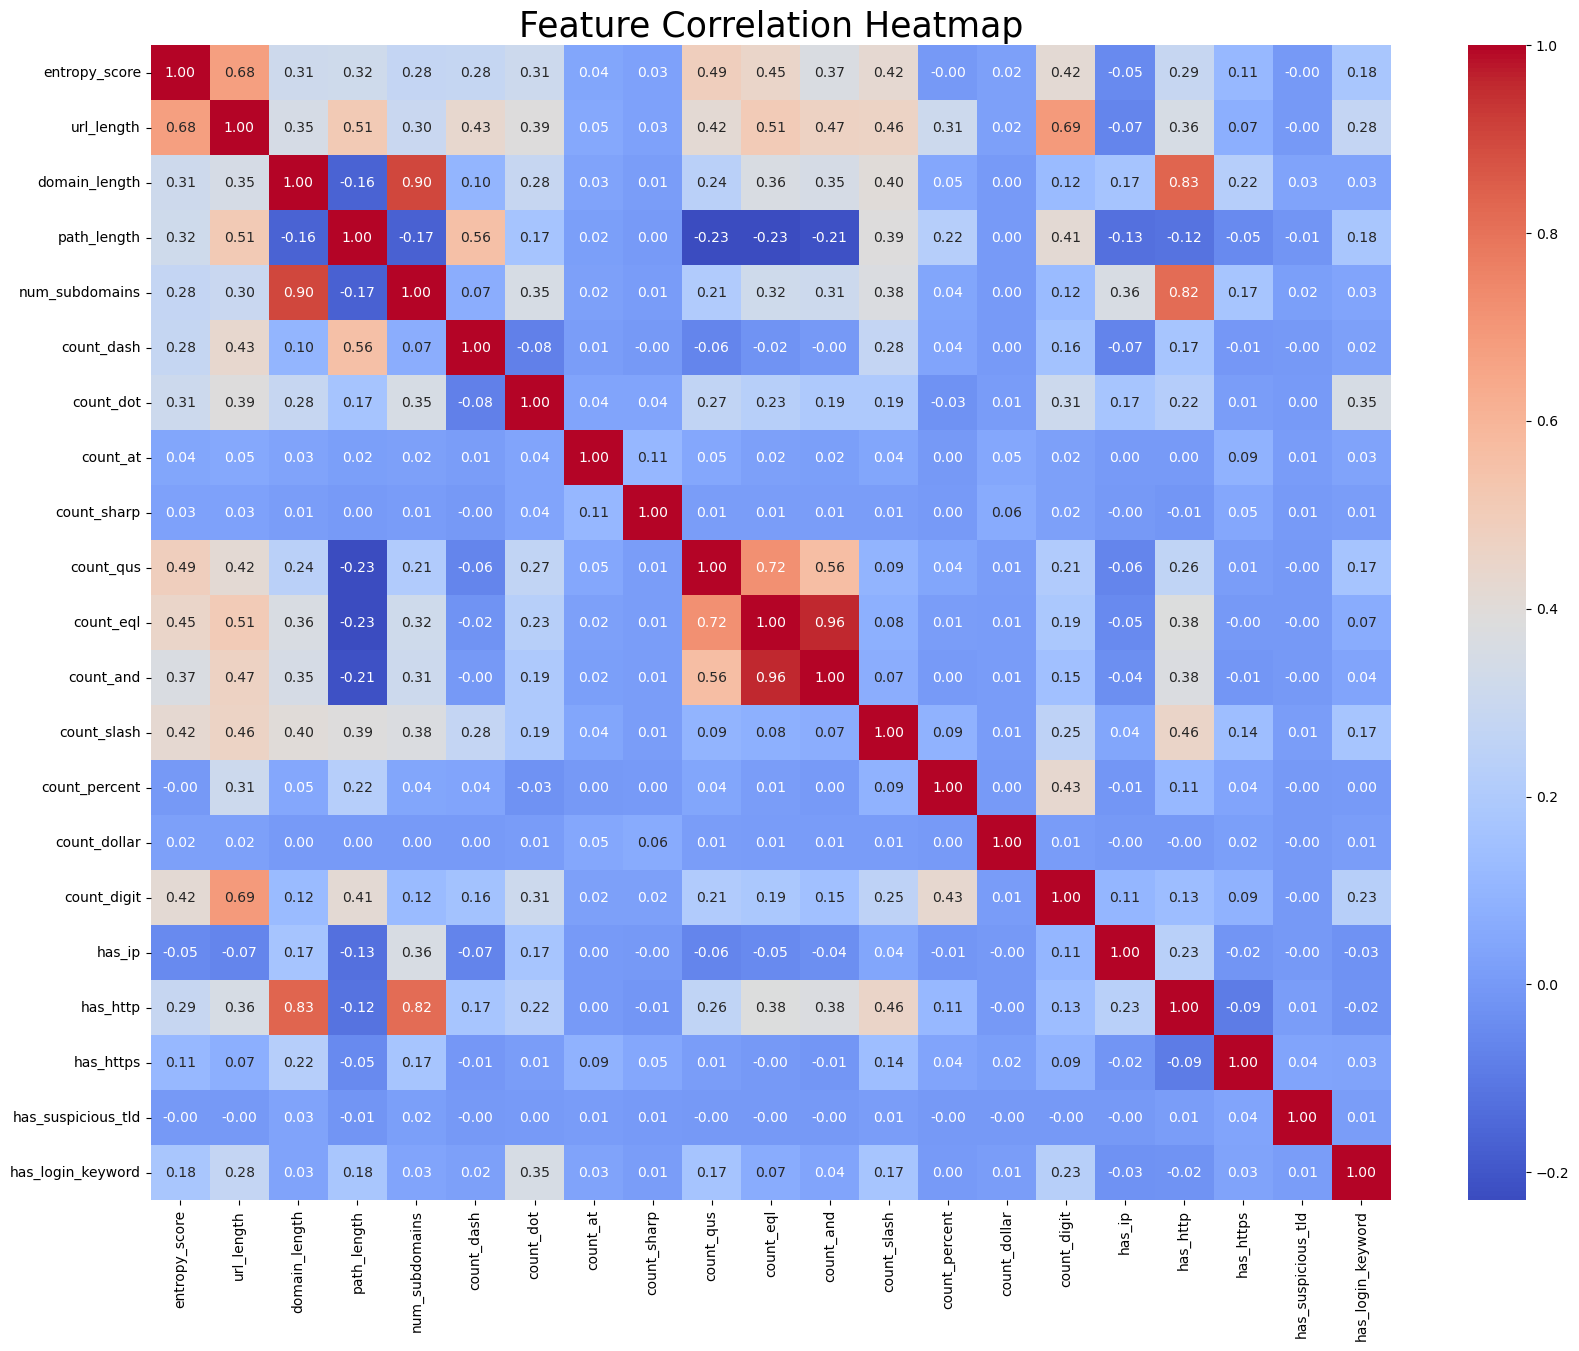

In [33]:
plt.figure(figsize=(20, 15))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap", fontsize=25)
plt.show()

In [34]:
# spliting train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

print(f"Train Dataset Shape: {X_train.shape}, {y_train.shape}")
print(f"Test Dataset Shape: {X_test.shape}, {y_test.shape}")

Train Dataset Shape: (512900, 21), (512900,)
Test Dataset Shape: (128225, 21), (128225,)


In [35]:
# scale the dataset
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# save the scaler
joblib.dump(scaler, './files/scaler.pkl')

['./files/scaler.pkl']

In [36]:
# save the preprocess datasets
def save_data(data, columns, path):
    try:
        df = pd.DataFrame(data, columns=columns)    
        df.to_csv(path, index=False)
    except Exception as e:
        print(f"Unable to save {data}: {e}")

save_data(X_train, X.columns, './data/processed/X_train.csv')
save_data(y_train, ['label'], './data/processed/y_train.csv')
save_data(X_test, X.columns, './data/processed/X_test.csv')
save_data(y_test, ['label'], './data/processed/y_test.csv')

*****
# Model Building

### loading Train and Test datasets

In [9]:
# loading train and test datasets
X_train = pd.read_csv('./data/processed/X_train.csv')
y_train = pd.read_csv('./data/processed/y_train.csv')
X_test = pd.read_csv('./data/processed/X_test.csv')
y_test = pd.read_csv('./data/processed/y_test.csv')

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((512900, 21), (512900, 1), (128225, 21), (128225, 1))

In [10]:
# coommon data
# results_df = pd.DataFrame(columns=['model_name', 'train_acc', 'test_acc', 'precision', 'recall', 'f1score'])
class_names = {'benign': 0, 'defacement': 1, 'malware': 2, 'phishing': 3}

# loading teh model results
results_df = pd.read_csv('results/scores.csv')

### Baseline Score checking

In [9]:
def get_cvs(model, X, y, cv=5):
    cross_val_score(model, X, y, cv=cv)

cv_scores = {}
models = {
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'XGBooost': XGBClassifier(),
    'Naive Bayes': GaussianNB(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

for name, model in models.items():
    start = time.time()
    sc = cross_val_score(model, X_train, y_train)
    measure_time((time.time()-start), name)
    print(f"{name} Cross Validation Scores: {sc}")
    cv_scores[name] = sc

Random Forest Training Time: 0h 5m 47s 

Random Forest Cross Validation Scores: [0.93232599 0.93372977 0.93136089 0.93328134 0.9329109 ]
AdaBoost Training Time: 0h 1m 54s 

AdaBoost Cross Validation Scores: [0.32780269 0.39105089 0.379031   0.33905245 0.41933125]
Decision Tree Training Time: 0h 0m 19s 

Decision Tree Cross Validation Scores: [0.91829791 0.9186781  0.91842464 0.91890232 0.91916553]
KNN Training Time: 0h 8m 50s 

KNN Cross Validation Scores: [0.92771495 0.92904075 0.92864106 0.92911874 0.92863131]
XGBooost Training Time: 0h 0m 57s 

XGBooost Cross Validation Scores: [0.93254046 0.9332131  0.93136089 0.93311562 0.93266719]
Naive Bayes Training Time: 0h 0m 2s 

Naive Bayes Cross Validation Scores: [0.80369468 0.80380191 0.8029343  0.80148177 0.80431858]
CatBoost Training Time: 0h 11m 21s 

CatBoost Cross Validation Scores: [0.932248   0.93294014 0.9316046  0.93279392 0.93278417]


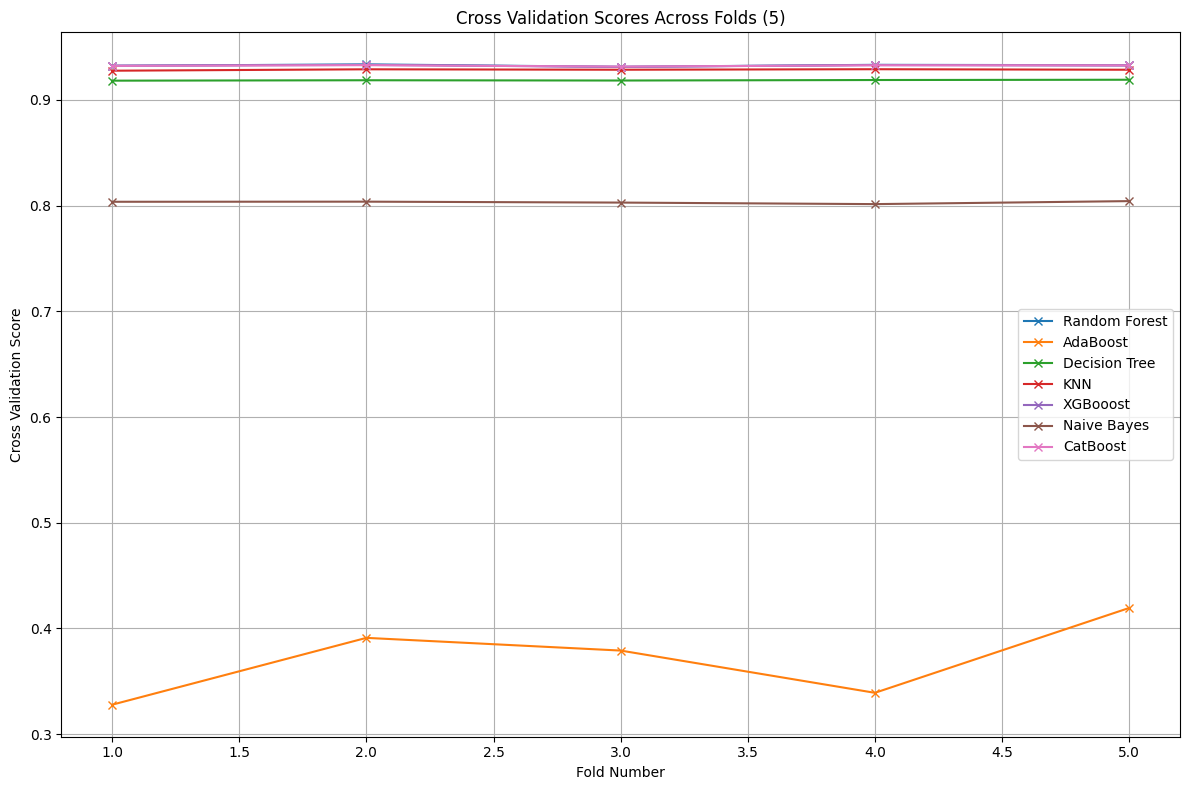

In [10]:
plt.figure(figsize=(12, 8))
folds = [1, 2, 3, 4, 5]

for name, scores in cv_scores.items():
    plt.plot(folds, scores, marker='x', label=name)
plt.title('Cross Validation Scores Across Folds (5)')
plt.xlabel('Fold Number')
plt.ylabel('Cross Validation Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(path+'/results/cv_scores_across_folds.png')
plt.show()
plt.close()

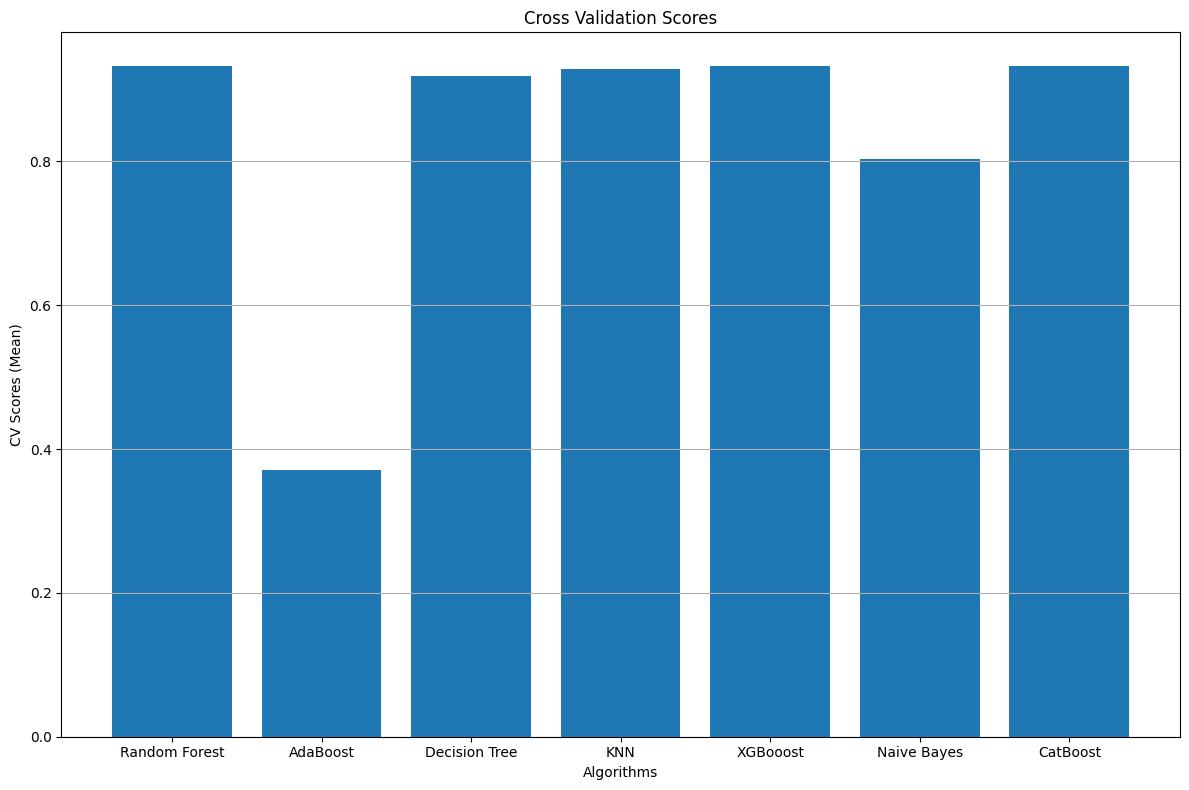

In [11]:
names = []
means = []
for k, v in cv_scores.items():
    names.append(k)
    means.append(np.mean(v))

plt.figure(figsize=(12, 8))
plt.bar(names, means)
plt.title("Cross Validation Scores")
plt.xlabel("Algorithms")
plt.ylabel("CV Scores (Mean)")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(path+'/results/cv_scores_across_models.png')
plt.show()
plt.close()

*****
### Decision Tree

In [11]:
### Hyperparameter Tuning(GridSearchCV)
classifier = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    {    # parameter grid
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': [10, 20, 30],
        'max_features': ['sqrt', 'log2']
    },
    cv=5,
    return_train_score=False
)

start = time.time()
classifier.fit(X_train, y_train)
measure_time((time.time()-start), "Decision Tree", Tune=True)

Decision Tree Hyperparameter Tuning Time: 0h 1m 10s 



In [12]:
pd.DataFrame(classifier.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.516850,0.037330,0.021212,0.002146,gini,10,sqrt,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.885757,0.893790,0.892981,0.874693,0.891802,0.887805,0.007137,13
1,0.505728,0.039956,0.020083,0.000617,gini,10,log2,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.885757,0.893790,0.892981,0.874693,0.891802,0.887805,0.007137,13
2,0.813980,0.051265,0.032948,0.000704,gini,20,sqrt,"{'criterion': 'gini', 'max_depth': 20, 'max_fe...",0.922841,0.927013,0.924790,0.925531,0.925327,0.925100,0.001349,1
3,0.803965,0.036812,0.032966,0.000787,gini,20,log2,"{'criterion': 'gini', 'max_depth': 20, 'max_fe...",0.922841,0.927013,0.924790,0.925531,0.925327,0.925100,0.001349,1
4,0.896765,0.031130,0.042212,0.001038,gini,30,sqrt,"{'criterion': 'gini', 'max_depth': 30, 'max_fe...",0.921057,0.921642,0.922334,0.923299,0.921954,0.922057,0.000749,7
5,0.892024,0.036650,0.042231,0.000603,gini,30,log2,"{'criterion': 'gini', 'max_depth': 30, 'max_fe...",0.921057,0.921642,0.922334,0.923299,0.921954,0.922057,0.000749,7
6,0.521761,0.017362,0.020896,0.000649,entropy,10,sqrt,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.883554,0.875093,0.886508,0.868795,0.895106,0.881811,0.009126,15
7,0.531916,0.027091,0.020631,0.000240,entropy,10,log2,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.883554,0.875093,0.886508,0.868795,0.895106,0.881811,0.009126,15
8,0.780971,0.033979,0.032760,0.000677,entropy,20,sqrt,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.925950,0.924381,0.923591,0.922129,0.924147,0.924040,0.001235,3
9,0.771052,0.021935,0.033830,0.001671,entropy,20,log2,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.925950,0.924381,0.923591,0.922129,0.924147,0.924040,0.001235,3


In [13]:
classifier.best_params_

{'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt'}

In [14]:
# Decision Tree Model Trainings
dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=20, max_features='sqrt', random_state=42)

start = time.time()
dt_classifier.fit(X_train,y_train)
measure_time((time.time()-start), "Decision Tree")

Decision Tree Training Time: 0h 0m 0s 



             Decision Tree Classification Results 

Train Accuracy: 0.9380
Test Accuracy:  0.9274
Precision:      0.9246
Recall:         0.9274
F1 Score:       0.9250

             Decision Tree Classification Report 

              precision    recall  f1-score   support

      benign       0.94      0.97      0.96     85504
  defacement       0.95      0.98      0.96     19142
     malware       0.95      0.87      0.91      4707
    phishing       0.82      0.69      0.75     18872

    accuracy                           0.93    128225
   macro avg       0.91      0.88      0.89    128225
weighted avg       0.92      0.93      0.92    128225



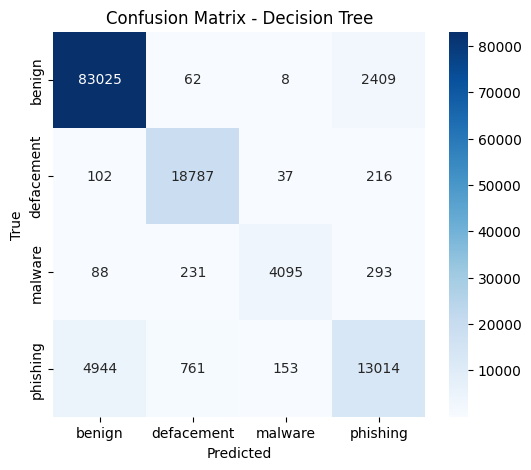

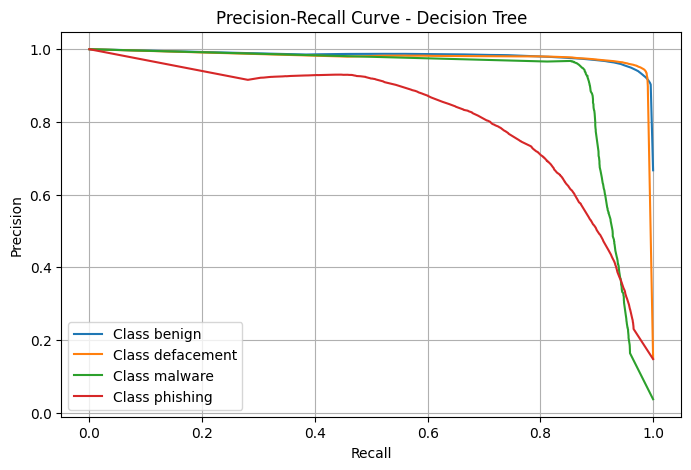

Model Saving...
Results Saving...


In [17]:
# save and print the classification report of Decision Tree Model 
results_df = evaluate_model(dt_classifier, "Decision Tree", X_train, y_train, X_test, y_test, results_df, class_names, './results/decision_tree')

# saving the classifier model
print("Model Saving...")
joblib.dump(dt_classifier, 'models/decision_tree_classifier_model.pkl')
print("Results Saving...")
results_df.to_csv('results/scores.csv')

*****
### Random Forest

In [19]:
### Hyperparameter Tuning(GridSearchCV)
classifier = GridSearchCV(
    RandomForestClassifier(random_state=42),
    {    # parameter grid
        'n_estimators': [50, 100, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [10, 20, 40]
    },
    cv=5,
    return_train_score=False
)

start = time.time()
classifier.fit(X_train, y_train)
measure_time((time.time()-start), "Random Forest", Tune=True)

Random Forest Hyperparameter Tuning Time: 2h 2m 48s 



In [20]:
pd.DataFrame(classifier.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,24.016187,0.701486,0.648164,0.030446,gini,10,50,"{'criterion': 'gini', 'max_depth': 10, 'n_esti...",0.908715,0.909846,0.911182,0.910431,0.909359,0.909906,0.000851,14
1,45.559301,0.758415,1.224489,0.016733,gini,10,100,"{'criterion': 'gini', 'max_depth': 10, 'n_esti...",0.908491,0.910996,0.910684,0.909778,0.908501,0.909690,0.001054,15
2,92.624856,0.956505,2.458233,0.055532,gini,10,200,"{'criterion': 'gini', 'max_depth': 10, 'n_esti...",0.908276,0.910294,0.910626,0.910675,0.910226,0.910019,0.000889,13
3,35.274747,0.771957,1.326228,0.045319,gini,20,50,"{'criterion': 'gini', 'max_depth': 20, 'n_esti...",0.935562,0.935757,0.935241,0.936128,0.936333,0.935804,0.000390,6
4,73.674562,1.905247,2.616281,0.043925,gini,20,100,"{'criterion': 'gini', 'max_depth': 20, 'n_esti...",0.935543,0.936255,0.935670,0.935884,0.936508,0.935972,0.000361,5
5,140.769444,1.267565,5.230229,0.161775,gini,20,200,"{'criterion': 'gini', 'max_depth': 20, 'n_esti...",0.935455,0.936420,0.935533,0.935972,0.936498,0.935976,0.000433,4
6,38.518423,0.903835,1.830184,0.106056,gini,40,50,"{'criterion': 'gini', 'max_depth': 40, 'n_esti...",0.932160,0.933837,0.931926,0.933301,0.932989,0.932843,0.000711,11
7,77.983830,1.264690,3.561043,0.074866,gini,40,100,"{'criterion': 'gini', 'max_depth': 40, 'n_esti...",0.932482,0.934285,0.931878,0.933418,0.933252,0.933063,0.000824,9
8,155.112314,2.649647,7.118201,0.242580,gini,40,200,"{'criterion': 'gini', 'max_depth': 40, 'n_esti...",0.932618,0.934315,0.931800,0.933515,0.933476,0.933145,0.000861,7
9,24.597476,0.278250,0.670868,0.015581,entropy,10,50,"{'criterion': 'entropy', 'max_depth': 10, 'n_e...",0.905752,0.906434,0.906668,0.905732,0.906268,0.906171,0.000373,17


In [21]:
classifier.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 200}

In [24]:
# Random Forest Model Trainings
rf_classifier = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=20, random_state=42)

start = time.time()
rf_classifier.fit(X_train,y_train)
measure_time((time.time()-start), "Random Forest")

Random Forest Training Time: 0h 3m 32s 



             Random Forest Classification Results 

Train Accuracy: 0.9485
Test Accuracy:  0.9369
Precision:      0.9348
Recall:         0.9369
F1 Score:       0.9347

             Random Forest Classification Report 

              precision    recall  f1-score   support

      benign       0.95      0.98      0.96     85504
  defacement       0.96      0.99      0.97     19142
     malware       0.99      0.89      0.93      4707
    phishing       0.85      0.72      0.78     18872

    accuracy                           0.94    128225
   macro avg       0.94      0.89      0.91    128225
weighted avg       0.93      0.94      0.93    128225



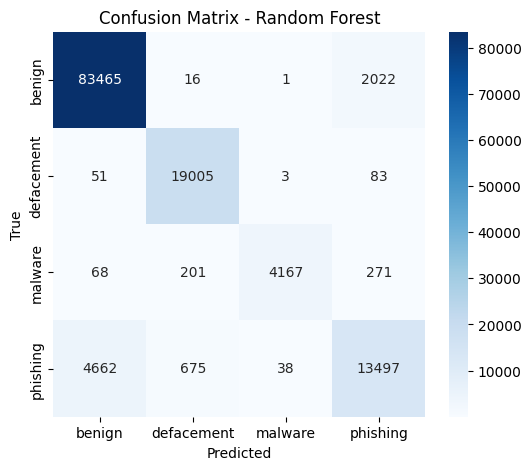

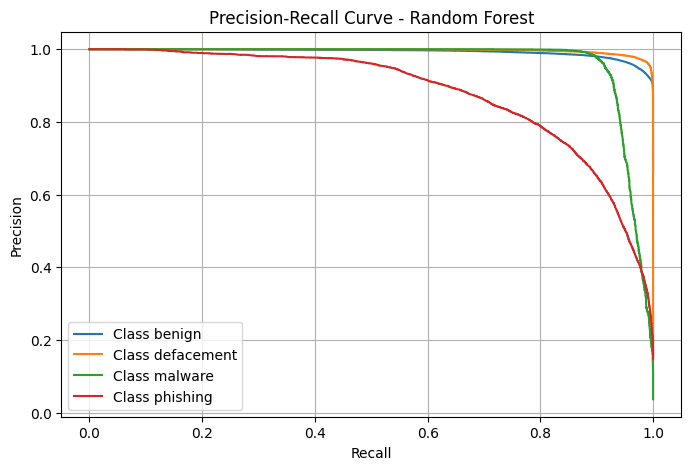

Results Saving...


In [27]:
# save and print the classification report of Random Forest Model 
results_df = evaluate_model(rf_classifier, "Random Forest", X_train, y_train, X_test, y_test, results_df, class_names, './results/random_forest_')

# saving the classifier model
joblib.dump(dt_classifier, 'models/random_forest_classifier_model.pkl')
print("Results Saving...")
results_df.to_csv('results/scores.csv')

*****
### XGBoost

In [30]:
### Hyperparameter Tuning(GridSearchCV)
classifier = GridSearchCV(
    XGBClassifier(random_state=42),
    {    # parameter grid
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.001],
        'max_depth': [10, 20, 40]
    },
    cv=5,
    return_train_score=False
)

start = time.time()
classifier.fit(X_train, y_train)
measure_time((time.time()-start), "XGBoost", Tune=True)

XGBoost Hyperparameter Tuning Time: 0h 59m 59s 



In [31]:
pd.DataFrame(classifier.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.934821,0.602346,0.318347,0.017039,0.01,10,50,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.920911,0.921242,0.920891,0.921154,0.921700,0.921180,0.000294,15
1,13.877490,0.999304,0.642943,0.025323,0.01,10,100,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.922119,0.923416,0.922207,0.922509,0.924079,0.922866,0.000761,14
2,28.073233,0.221660,1.632149,0.009487,0.01,10,200,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.924673,0.926487,0.925200,0.925814,0.926262,0.925687,0.000671,13
3,16.560150,0.681026,1.252055,0.044436,0.01,20,50,"{'learning_rate': 0.01, 'max_depth': 20, 'n_es...",0.933759,0.934432,0.933779,0.934636,0.934373,0.934196,0.000359,5
4,32.641964,0.785468,2.802460,0.044845,0.01,20,100,"{'learning_rate': 0.01, 'max_depth': 20, 'n_es...",0.934812,0.935514,0.934315,0.935387,0.935436,0.935093,0.000462,2
5,65.087348,0.593761,6.128648,0.361949,0.01,20,200,"{'learning_rate': 0.01, 'max_depth': 20, 'n_es...",0.935650,0.936781,0.935553,0.936869,0.936713,0.936313,0.000584,1
6,23.827063,0.518378,1.603566,0.073188,0.01,40,50,"{'learning_rate': 0.01, 'max_depth': 40, 'n_es...",0.933593,0.934822,0.933320,0.934071,0.934285,0.934018,0.000527,6
7,49.594363,1.069436,3.506598,0.192215,0.01,40,100,"{'learning_rate': 0.01, 'max_depth': 40, 'n_es...",0.933769,0.935446,0.933973,0.934783,0.934753,0.934545,0.000607,4
8,104.454089,2.356835,7.474709,0.219928,0.01,40,200,"{'learning_rate': 0.01, 'max_depth': 40, 'n_es...",0.933954,0.935523,0.933895,0.934822,0.934597,0.934558,0.000601,3
9,6.729573,0.149167,0.314775,0.003276,0.001,10,50,"{'learning_rate': 0.001, 'max_depth': 10, 'n_e...",0.919263,0.920199,0.918844,0.919107,0.919867,0.919456,0.000501,18


In [32]:
classifier.best_params_

{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 200}

In [33]:
# XGBoost Model Training
xgb_classifier = XGBClassifier(n_estimators=200, max_depth=20, learning_rate=0.01, random_state=42)

start = time.time()
xgb_classifier.fit(X_train,y_train)
measure_time((time.time()-start), "XGBoost")

XGBoost Training Time: 0h 1m 19s 



             XGBoost Classification Results 

Train Accuracy: 0.9533
Test Accuracy:  0.9377
Precision:      0.9359
Recall:         0.9377
F1 Score:       0.9362

             XGBoost Classification Report 

              precision    recall  f1-score   support

      benign       0.95      0.97      0.96     85504
  defacement       0.96      0.99      0.98     19142
     malware       0.98      0.89      0.93      4707
    phishing       0.83      0.74      0.79     18872

    accuracy                           0.94    128225
   macro avg       0.93      0.90      0.91    128225
weighted avg       0.94      0.94      0.94    128225



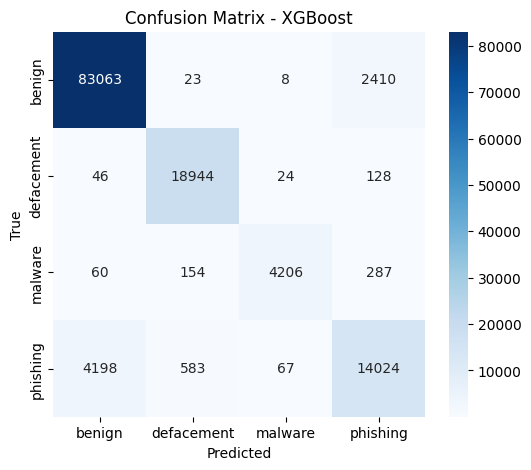

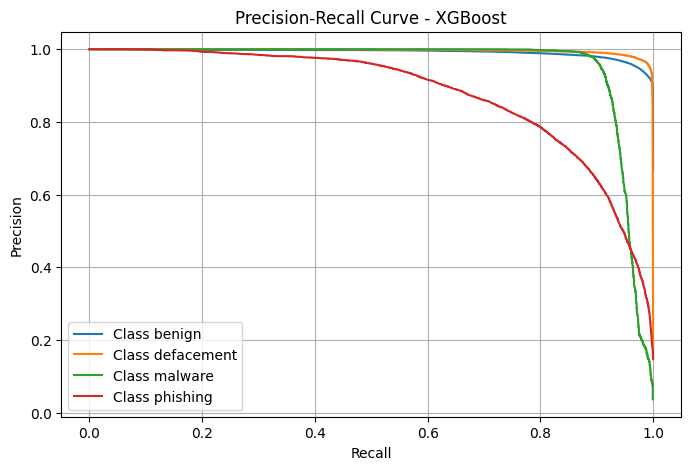

Model Saving...
Results Saving...


In [34]:
# save and print the classification report of XGBoost Model 
results_df = evaluate_model(xgb_classifier, "XGBoost", X_train, y_train, X_test, y_test, results_df, class_names, './results/xgboost_')

# saving the classifier model
print("Model Saving...")
joblib.dump(xgb_classifier, 'models/xgboost_classifier_model.pkl')
print("Results Saving...")
results_df.to_csv('results/scores.csv')

*****
### CatBoost

In [15]:
### Hyperparameter Tuning(GridSearchCV)
classifier = GridSearchCV(
    CatBoostClassifier(random_state=42, verbose=0),
    {    # parameter grid
        'iterations': [100, 150, 200],
        'learning_rate': [0.01, 0.001],
        'depth': [10, 15, 20]
    },
    cv=5,
    return_train_score=False
)

start = time.time()
classifier.fit(X_train, y_train)
measure_time((time.time()-start), "CatBoost", Tune=True)

CatBoost Hyperparameter Tuning Time: 6h 3m 55s 



In [17]:
pd.DataFrame(classifier.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,45.407690,0.305315,0.074895,0.000588,10,100,0.01,"{'depth': 10, 'iterations': 100, 'learning_rat...",0.893771,0.893751,0.894385,0.895730,0.896900,0.894907,0.001229,9
1,45.570155,0.283600,0.074864,0.000172,10,100,0.001,"{'depth': 10, 'iterations': 100, 'learning_rat...",0.887181,0.888263,0.888195,0.888555,0.889676,0.888374,0.000800,12
2,68.561934,0.105985,0.094532,0.004930,10,150,0.01,"{'depth': 10, 'iterations': 150, 'learning_rat...",0.897212,0.896958,0.896783,0.898430,0.898879,0.897653,0.000842,8
3,68.802406,0.130791,0.098927,0.013582,10,150,0.001,"{'depth': 10, 'iterations': 150, 'learning_rat...",0.887629,0.888799,0.888419,0.889257,0.889774,0.888776,0.000731,11
4,91.644406,0.639026,0.107087,0.000992,10,200,0.01,"{'depth': 10, 'iterations': 200, 'learning_rat...",0.900224,0.900585,0.900526,0.902203,0.903139,0.901336,0.001137,7
5,90.932050,0.209124,0.106462,0.001160,10,200,0.001,"{'depth': 10, 'iterations': 200, 'learning_rat...",0.887766,0.888848,0.888507,0.889423,0.890027,0.888914,0.000773,10
6,418.447917,3.100271,0.096503,0.000959,15,100,0.01,"{'depth': 15, 'iterations': 100, 'learning_rat...",0.910772,0.912088,0.911230,0.912254,0.913297,0.911928,0.000875,3
7,415.993548,1.007980,0.097660,0.000416,15,100,0.001,"{'depth': 15, 'iterations': 100, 'learning_rat...",0.901696,0.902466,0.901111,0.902320,0.903490,0.902217,0.000798,6
8,625.047145,3.888366,0.125013,0.002718,15,150,0.01,"{'depth': 15, 'iterations': 150, 'learning_rat...",0.914272,0.916260,0.914506,0.914983,0.916338,0.915272,0.000870,2
9,624.762311,2.728719,0.127324,0.001938,15,150,0.001,"{'depth': 15, 'iterations': 150, 'learning_rat...",0.901862,0.902466,0.901540,0.902808,0.903880,0.902511,0.000816,5


In [16]:
classifier.best_params_

{'depth': 15, 'iterations': 200, 'learning_rate': 0.01}

In [11]:
# CatBoost Model Training
catb_classifier = CatBoostClassifier(iterations=200, depth=15, learning_rate=0.01, random_state=42, verbose=0)

start = time.time()
catb_classifier.fit(X_train,y_train)
measure_time((time.time()-start), "CatBoost")

CatBoost Training Time: 0h 16m 4s 



             CatBoost Classification Results 

Train Accuracy: 0.9206
Test Accuracy:  0.9193
Precision:      0.9164
Recall:         0.9193
F1 Score:       0.9157

             CatBoost Classification Report 

              precision    recall  f1-score   support

      benign       0.93      0.97      0.95     85504
  defacement       0.91      0.98      0.94     19142
     malware       0.98      0.80      0.88      4707
    phishing       0.82      0.65      0.73     18872

    accuracy                           0.92    128225
   macro avg       0.91      0.85      0.88    128225
weighted avg       0.92      0.92      0.92    128225



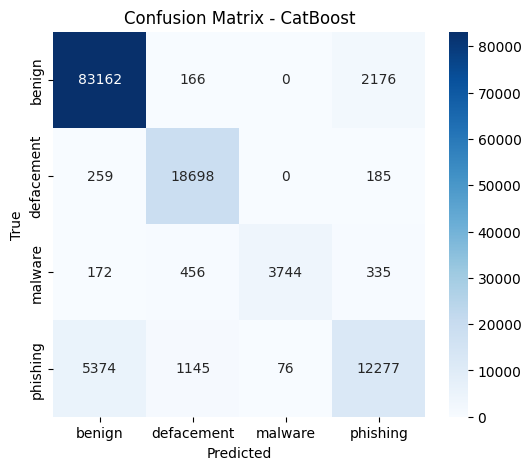

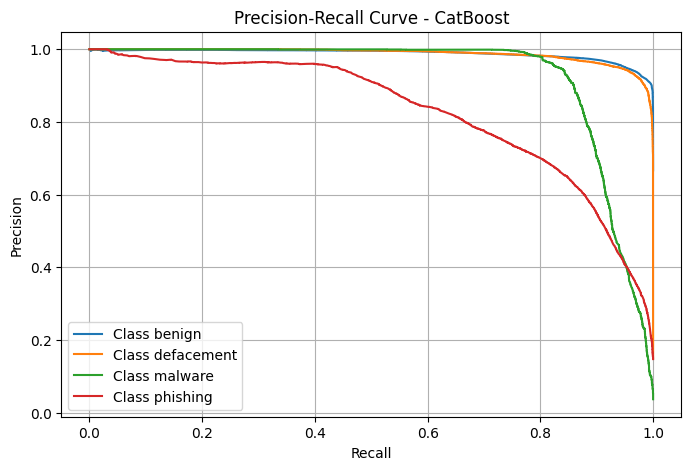

Model Saving...
Results Saving...


In [12]:
# save and print the classification report of CatBoost Model 
results_df = evaluate_model(catb_classifier, "CatBoost", X_train, y_train, X_test, y_test, results_df, class_names, './results/catboost_')

# saving the classifier model
print("Model Saving...")
joblib.dump(catb_classifier, 'models/catboost_classifier_model.pkl')
print("Results Saving...")
results_df.to_csv('results/scores.csv')

*****
### KNN

In [16]:
# neighbors value finding
scores_uniform = []
scores_distance = []
for x in range(4,10):
    knn = KNeighborsClassifier(n_neighbors=x, weights='uniform', n_jobs=-1)
    knn.fit(X_train, y_train)
    scores_uniform.append(knn.score(X_test, y_test))
    knn = KNeighborsClassifier(n_neighbors=x, weights='distance', n_jobs=-1)
    knn.fit(X_train, y_train)
    scores_distance.append(knn.score(X_test, y_test))

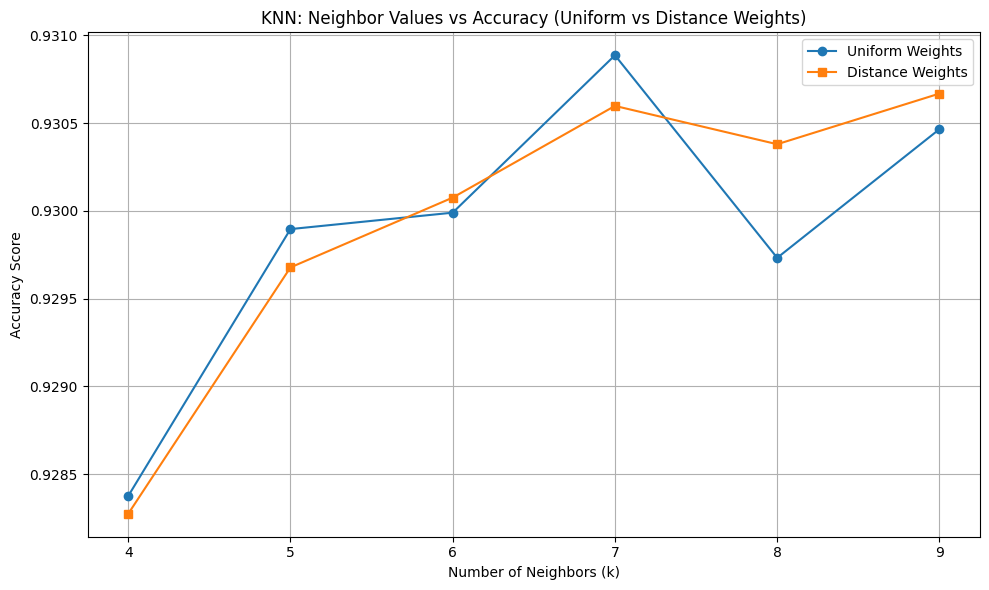

In [20]:
neighbors = range(4, 10)

plt.figure(figsize=(10, 6))
plt.plot(neighbors, scores_uniform, marker='o', label='Uniform Weights')
plt.plot(neighbors, scores_distance, marker='s', label='Distance Weights')

plt.xticks(np.arange(4, 10, 1))
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy Score")
plt.title("KNN: Neighbor Values vs Accuracy (Uniform vs Distance Weights)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

In [21]:
# KNN Model Training
knn_classifier = KNeighborsClassifier(n_neighbors=7, weights='uniform', n_jobs=-1)

start = time.time()
knn_classifier.fit(X_train,y_train)
measure_time((time.time()-start), "KNN")

KNN Training Time: 0h 0m 0s 



             KNN Classification Results 

Train Accuracy: 0.9427
Test Accuracy:  0.9309
Precision:      0.9286
Recall:         0.9309
F1 Score:       0.9291

             KNN Classification Report 

              precision    recall  f1-score   support

      benign       0.95      0.97      0.96     85504
  defacement       0.95      0.99      0.97     19142
     malware       0.96      0.89      0.92      4707
    phishing       0.82      0.72      0.76     18872

    accuracy                           0.93    128225
   macro avg       0.92      0.89      0.90    128225
weighted avg       0.93      0.93      0.93    128225



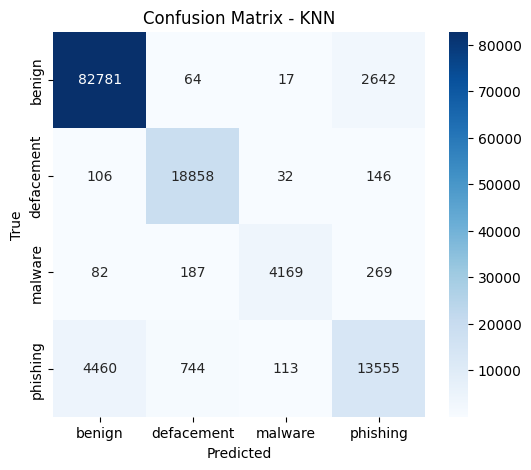

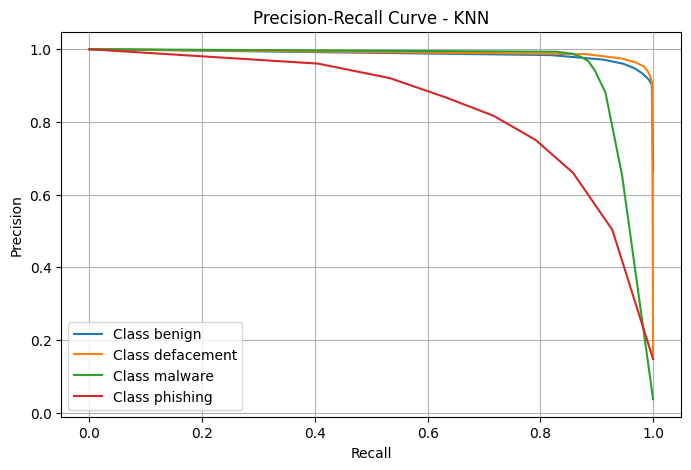

Model Saving...
Results Saving...


In [22]:
# save and print the classification report of KNN Model 
results_df = evaluate_model(knn_classifier, "KNN", X_train, y_train, X_test, y_test, results_df, class_names, './results/knn_')

# saving the classifier model
print("Model Saving...")
joblib.dump(catb_classifier, 'models/knn_classifier_model.pkl')
print("Results Saving...")
results_df.to_csv('results/scores.csv')

*****
### Voting Classifier

In [22]:
# initialize classifier models with best hypperparameters for voting classifier
dt = DecisionTreeClassifier(criterion='gini', max_depth=20, max_features='sqrt', random_state=42)
rf = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=20, random_state=42)
xgb = XGBClassifier(n_estimators=200, max_depth=20, learning_rate=0.01, random_state=42)
knn = KNeighborsClassifier(n_neighbors=7, weights='uniform', n_jobs=-1)

In [23]:
# init estimators
estimators = [
    ('decision_tree', dt), 
    ('random_forest', rf), 
    ('xgboost', xgb), 
    ('knn', knn)
]

# initialize the voting classifier with hard voting
voting_classifier = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1, verbose=True)

# Voting Classifier Training
start = time.time()
voting_classifier.fit(X_train,y_train)
measure_time((time.time()-start), "Voting Classifier")

Voting Classifier Training Time: 0h 3m 22s 



In [25]:
voting_classifier

VotingClassifier(estimators=[('decision_tree',
                              DecisionTreeClassifier(max_depth=20,
                                                     max_features='sqrt',
                                                     random_state=42)),
                             ('random_forest',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=20,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsampl...
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=20,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('knn',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=7))],
                 n_jobs=-1, verbose=True)

[Voting] ............ (2 of 4) Processing random_forest, total= 3.3min
             Voting Classifier Classification Results 

Train Accuracy: 0.9478
Test Accuracy:  0.9367
Precision:      0.9345
Recall:         0.9367
F1 Score:       0.9342

             Voting Classifier Classification Report 

              precision    recall  f1-score   support

      benign       0.94      0.98      0.96     85504
  defacement       0.95      0.99      0.97     19142
     malware       0.99      0.89      0.93      4707
    phishing       0.86      0.71      0.77     18872

    accuracy                           0.94    128225
   macro avg       0.94      0.89      0.91    128225
weighted avg       0.93      0.94      0.93    128225



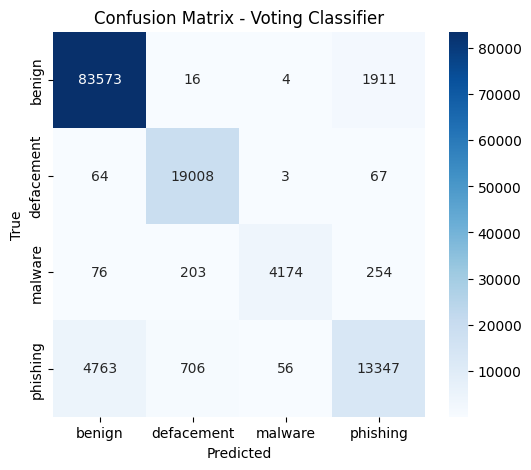

Model Saving...
Results Saving...


In [26]:
# save and print the classification report of Voting Classifier 
results_df = evaluate_model(voting_classifier, "Voting Classifier", X_train, y_train, X_test, y_test, results_df, class_names, './results/voting_classifier_')

# saving the classifier model
print("Model Saving...")
joblib.dump(voting_classifier, 'models/voting_classifier_model.pkl')
print("Results Saving...")
results_df.to_csv('results/scores.csv')

*****
# Model Analysis

## Inference Time Analysis

In [12]:
# loading the trained models
dt_classifier = joblib.load("./models/decision_tree_classifier_model.pkl")
rf_classifier = joblib.load("./models/random_forest_classifier_model.pkl")
xgb_classifier = joblib.load("./models/xgboost_classifier_model.pkl")
knn_classifier = joblib.load("./models/knn_classifier_model.pkl")
catb_classifier = joblib.load("./models/catboost_classifier_model.pkl")
voting_classifier = joblib.load("./models/voting_classifier_model.pkl")

In [64]:
models = {
    'Decision Tree': dt_classifier,
    'Random Forest': rf_classifier,
    'XGBoost': xgb_classifier,
    'KNN': knn_classifier,
    'CatBoost': catb_classifier,
    'Voting Classifier': voting_classifier
}

times = {}
sample = X_test[:1].values

for name, model in models.items():
    start = time.time()
    model.predict(sample)
    end = time.time()
    times[name] = np.round(((end-start)*1000), 4)

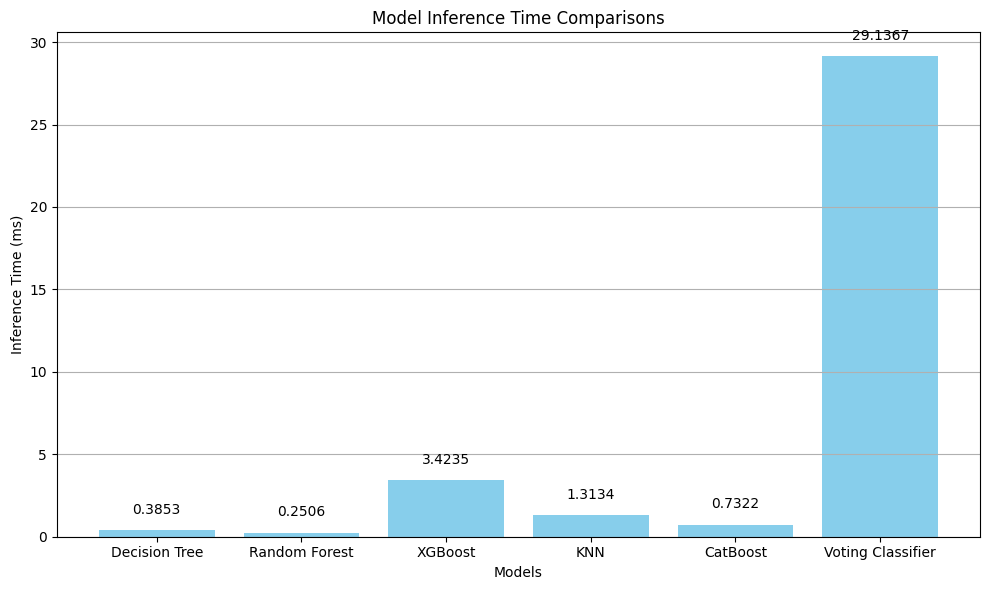

In [76]:
plt.figure(figsize=(10, 6))
bars = plt.bar(times.keys(), times.values(), color='skyblue')
plt.xlabel("Models")
plt.ylabel("Inference Time (ms)")
plt.title("Model Inference Time Comparisons")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height+1, f'{height}', ha='center', fontsize=10)
plt.tight_layout()
plt.grid(axis='y')
plt.show()
plt.close()

## Results Analysis

In [113]:
results = results_df.iloc[:,1:]
results = results.drop(columns='train_acc', axis=1)

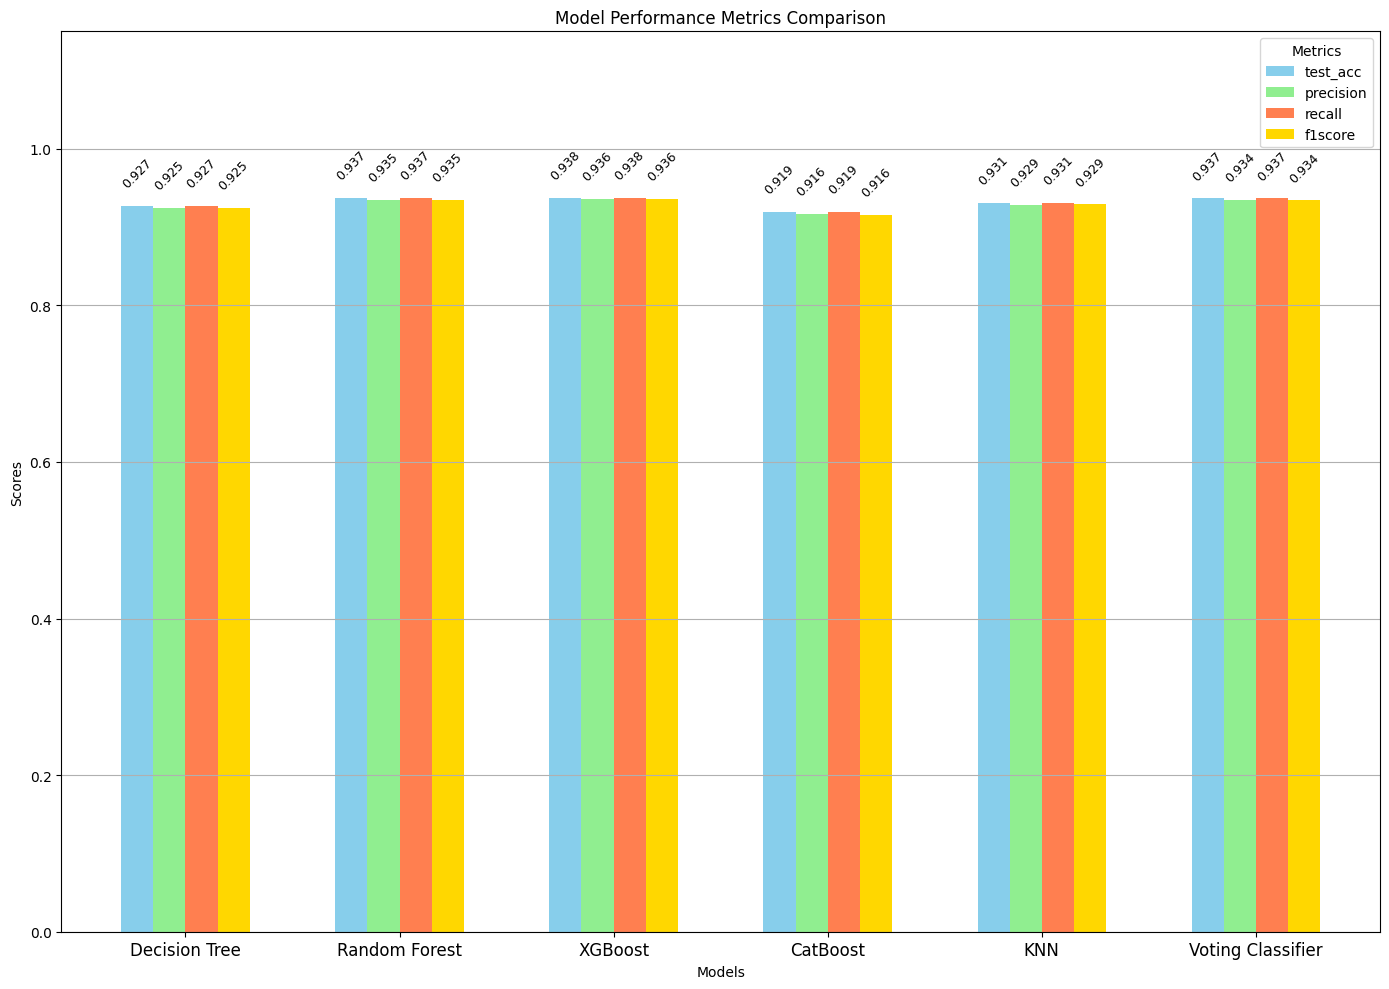

In [124]:
bar_width = 0.15
x = np.arange(len(results)) 

colors = ['skyblue', 'lightgreen', 'coral', 'gold']


plt.figure(figsize=(14, 10))

for i, metric in enumerate(results.columns[1:]):
    bars = plt.bar(x + i * bar_width, results[metric], width=bar_width, label=metric, color=colors[i])
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.3f}',
                 ha='center', va='bottom', fontsize=9, rotation=45)

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Metrics Comparison')
plt.xticks(x + bar_width * (len(results.columns[1:]) - 1) / 2, results['model_name'], fontsize=12)
plt.ylim(0, 1.15)  

plt.legend(title='Metrics')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

## ROC AUC Scores

In [163]:
models.pop('Voting Classifier')

VotingClassifier(estimators=[('decision_tree',
                              DecisionTreeClassifier(max_depth=20,
                                                     max_features='sqrt',
                                                     random_state=42)),
                             ('random_forest',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=20,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsampl...
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=20,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('knn',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=7))],
                 n_jobs=-1, verbose=True)

In [164]:
models

{'Decision Tree': DecisionTreeClassifier(max_depth=20, max_features='sqrt', random_state=42),
 'Random Forest': DecisionTreeClassifier(max_depth=20, max_features='sqrt', random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.01, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=20, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=200, n_jobs=None,
               num_parallel_tree=None, objective='multi:softprob', ...),
 'KNN': <catboost.core.Ca

In [165]:
scores = {}

def get_roc_auc(model, X, y):
    proba = model.predict_proba(X)
    return np.round(roc_auc_score(y, proba, multi_class='ovr'),4)

for name, model in models.items():
    scores[name] = get_roc_auc(model, X_test, y_test)

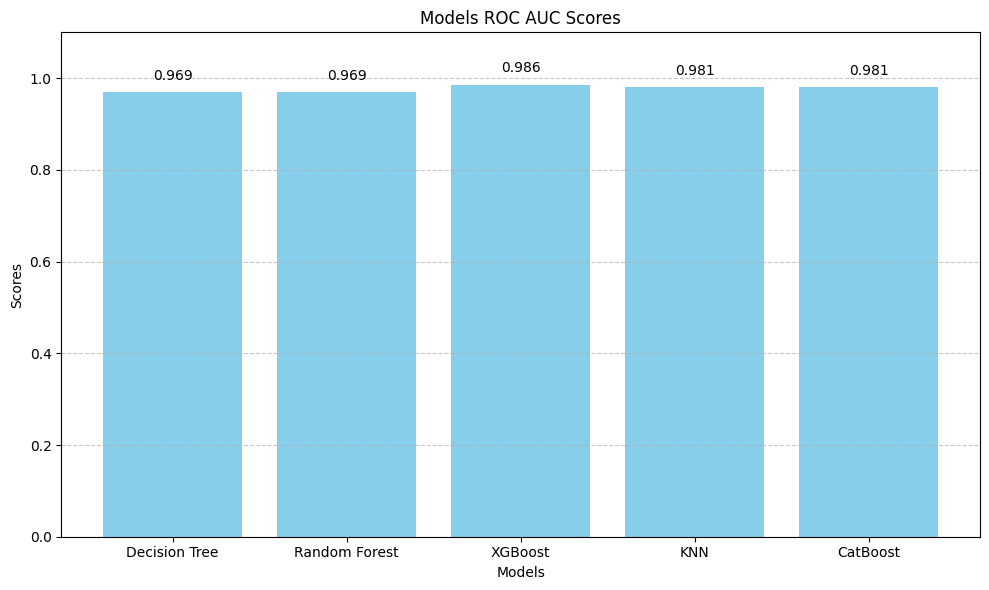

In [173]:
plt.figure(figsize=(10, 6))
bars = plt.bar(scores.keys(), scores.values(), color='skyblue')

plt.xlabel("Models")
plt.ylabel("Scores")
plt.title("Models ROC AUC Scores")
plt.ylim(0, 1.1) 

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{height:.3f}',
             ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Model Predictions

In [239]:
url = 'br-icloud.com.br'

scaler = joblib.load('tools/scaler.pkl')
decoder = joblib.load('tools/decoder.pkl')

# extract features from the url
extracted_features = list(get_feature(url).values())
extracted_features = np.array(extracted_features[1:]).reshape(1,-1)  # remove the first feature
scaled_features = scaler.transform(extracted_features)   # scale the features

# prediction
pred = xgb_classifier.predict(scaled_features)[0]
pred_class = decoder.inverse_transform([pred])[0]
proba = xgb_classifier.predict_proba(scaled_features)[0][pred]

print(f"URL Type: {pred_class.upper()}")
print(f"Prediction Confidence: {proba:.4f} %")

URL Type: PHISHING
Prediction Confidence: 0.7953 %
